In [14]:
# import the necessary packages
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import openpose as op
from gluoncv import model_zoo, data, utils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import imutils

# Task 1 : Identifying and masking a human

In [15]:
#pre trained model 
net1 = model_zoo.get_model('mask_rcnn_resnet50_v1b_coco', pretrained=True)

In [16]:
x, orig_img = data.transforms.presets.rcnn.load_test('imgg1.jpg')

In [17]:
#getting the maske region
ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in net1(x)]

In [18]:
# paint segmentation mask on images directly
width, height = orig_img.shape[1], orig_img.shape[0]
masks = utils.viz.expand_mask(masks, bboxes, (width, height), scores)
orig_img = utils.viz.plot_mask(orig_img, masks)

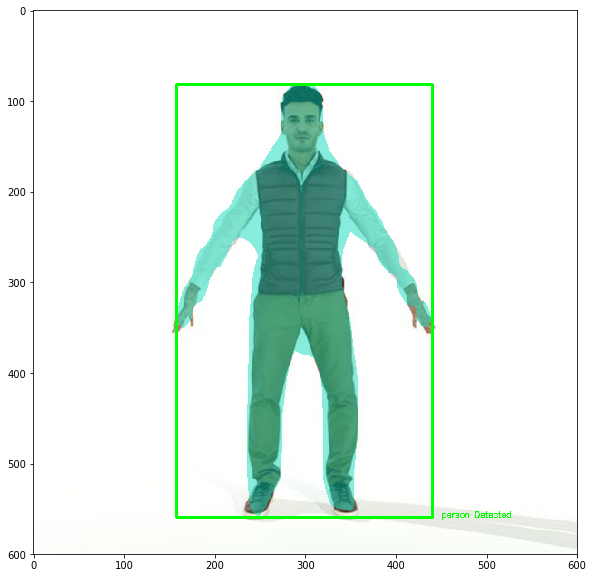

In [19]:
#lableling the person
for c in masks:
    rect = cv2.boundingRect(c)
    if rect[2] < 100 or rect[3] < 100: continue
    #print(cv2.contourArea(c))
    x1,y1,w,h = rect
    cv2.rectangle(orig_img,(x1,y1),(x1+w,y1+h),(0,255,0),2)
    cv2.putText(orig_img,'person Detected',(x1+w+10,y1+h),0,0.3,(0,255,0))
cv2.imwrite("Show.png",orig_img)
cv2.destroyAllWindows()
plt.figure(figsize=[10,10])
plt.imshow(orig_img)

# Task 2 : Body part detection 

In [20]:
#pre trained model
#MODE = "COCO"
protoFile = "pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]


In [21]:
# Loading the network 
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368

In [22]:
# loading the image 
frame = cv2.imread("Show.png")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

In [23]:
#passing through deep neural network
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]

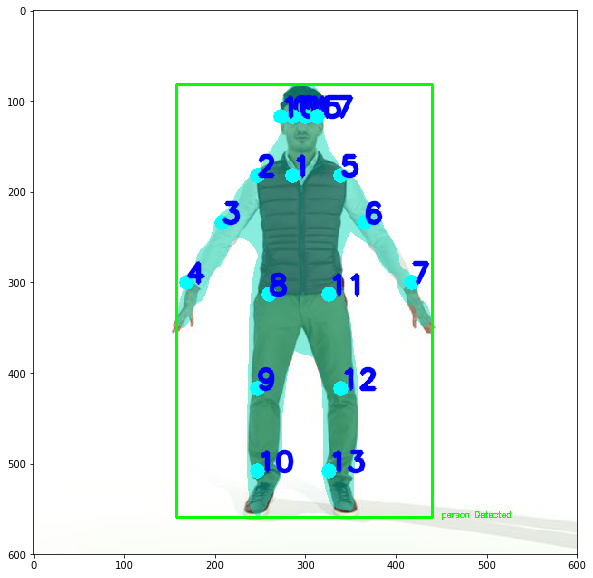

In [24]:
# gathering all the points 

'''Nose – 0, Neck – 1, Right Shoulder – 2, Right Elbow – 3, Right Wrist – 4,
Left Shoulder – 5, Left Elbow – 6, Left Wrist – 7, Right Hip – 8,
Right Knee – 9, Right Ankle – 10, Left Hip – 11, Left Knee – 12,
LAnkle – 13, Right Eye – 14, Left Eye – 15, Right Ear – 16,
Left Ear – 17, Background – 18'''

# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)


cv2.imwrite('Show1.png',frameCopy)
cv2.destroyAllWindows()
plt.figure(figsize=[10,10])
plt.imshow(frameCopy)

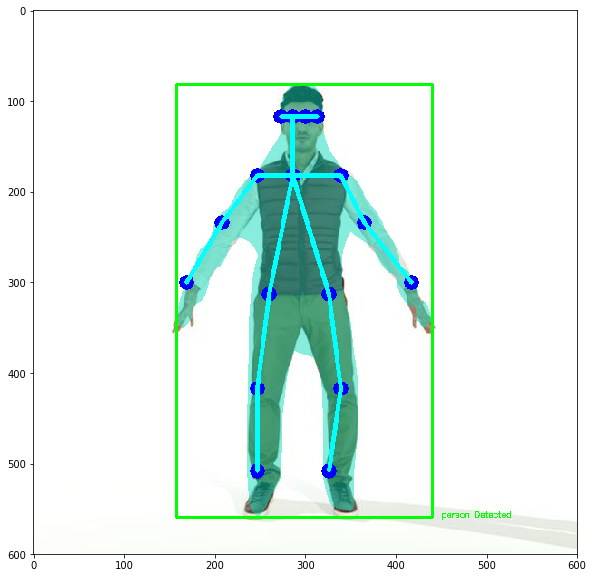

In [25]:
# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)
        
plt.figure(figsize=[10,10])
plt.imshow(frame)

# Body Measurements

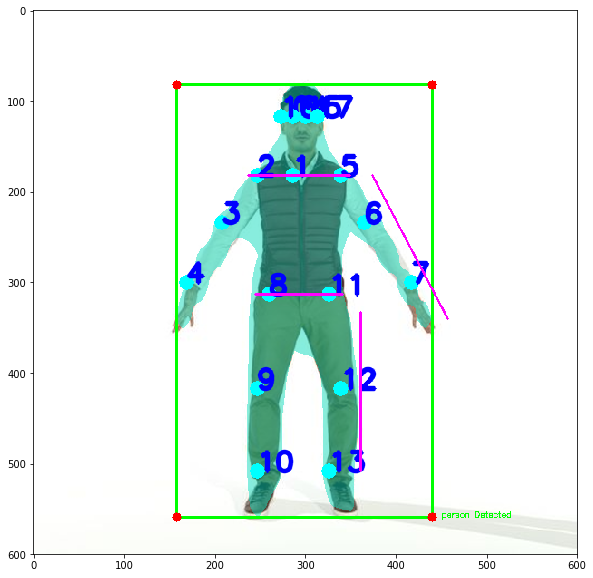

In [44]:
orig = cv2.imread("Show1.png")
cv2.line(orig,  (points[2][0]-10, points[2][1]), (points[5][0]+10, points[5][1]),(255, 0, 255), 2)
cv2.line(orig,  (points[8][0]-15, points[8][1]), (points[11][0]+15, points[11][1]),(255, 0, 255), 2)
cv2.line(orig,  (points[5][0]+35, points[5][1]), (points[7][0]+40, points[7][1]+40),(255, 0, 255), 2)
cv2.line(orig,  (points[11][0]+35, points[11][1]+20), (points[13][0]+35, points[13][1]),(255, 0, 255), 2)
cv2.circle(orig, (x1, y1), 5, (255, 0, 0), -1)
cv2.circle(orig, (x1, y1+h), 5, (255, 0, 0), -1)
cv2.circle(orig, (x1+w, y1), 5, (255, 0, 0), -1)
cv2.circle(orig, (x1+w, y1+h), 5, (255, 0, 0), -1)
plt.figure(figsize=[10,10])
plt.imshow(orig)
cv2.imwrite('Show3.png',orig)
cv2.destroyAllWindows()

In [45]:
# height and width in pixels 
height = dist.euclidean((x1, y1), (x1, y1+h))
width_shoulder = dist.euclidean((points[2][0]-10, points[2][1]), (points[5][0]+10, points[5][1]))
width_hip = dist.euclidean((points[8][0]-5, points[8][1]), (points[11][0]+5, points[11][1]))
Left_arm_length = dist.euclidean((points[5][0]+35, points[5][1]), (points[7][0]+15, points[7][1]+40))
Left_leg_length = dist.euclidean((points[11][0]+35, points[11][1]+20), (points[13][0]+35, points[13][1]))

In [46]:
# given height is 177.8 cm i.e 5'10 
height_cm = float(input("Height in cm:"))
one_pixel = height_cm/height

Height in cm:173.70


In [47]:
# measurement of some body parts in cm
width_shoulder_incm = width_shoulder*one_pixel
# sice we only have the frontal view could not get the exact hip mesurement hence ,
# as a default case taking hip size to be double
width_hip_incm = (width_hip * one_pixel) * 2
Left_arm_length_incm = Left_arm_length *one_pixel
Left_leg_length_incm = Left_leg_length *one_pixel

In [48]:
print("Shoulder in cm:", width_shoulder_incm)
print("Hip in cm:",width_hip_incm)
print("Left arm length in cm:",Left_arm_length_incm)
print("Left leg length in cm:",Left_leg_length_incm)

Shoulder in cm: 40.784905660377355
Hip in cm: 55.35094339622641
Left arm length in cm: 61.28996823689153
Left leg length in cm: 63.72641509433962
